# LAB 03.02 - Timeseries model

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()


replicating local resources


In [29]:
from local.lib.rlxmoocapi import submit, session
session.LoginSequence(endpoint=init.endpoint, course_id=init.course_id, lab_id="L03.02", varname="student");

logging in as sergio.zapatar@udea.edu.co ... please wait
using course session ai4eng.v1.udea.r2::2023.2
success!! you are logged in


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from local.lib import timeseries as ts
import pandas as pd
import os
from IPython.display import Image
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

## A synthetic timeseries

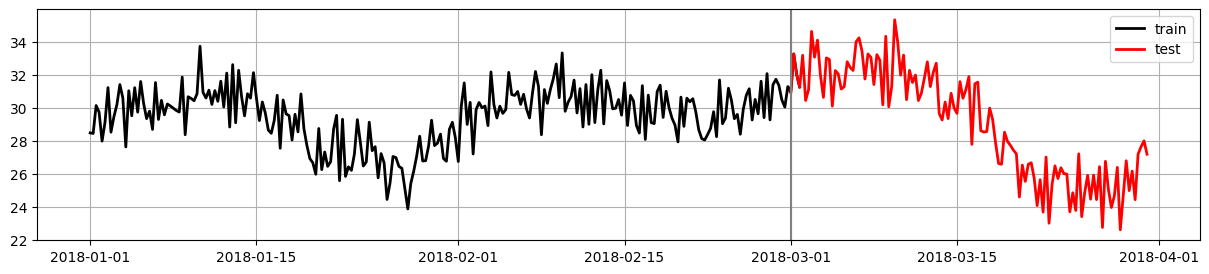

In [4]:

date_split = "2018-03-01"

idx = pd.date_range("2018-01-01", "2018-03-31", freq="6h")
i = np.linspace(-5,4,len(idx))
i = np.linspace(np.random.random()*5-5,np.random.random()*5+2,len(idx))
t = np.log(i**2+.3)*np.cos(4*i)
t += (np.random.normal(size=len(idx))*.4)
t = np.round(t*3+30,3)
d = pd.DataFrame(np.r_[[t]].T, columns=["signal"], index=idx)
d.index.name="date"

plt.figure(figsize=(15,3))
plt.plot(d[:date_split].index, d[:date_split].signal, color="black", lw="2", label="train");
plt.plot(d[date_split:].index, d[date_split:].signal, color="red", lw="2", label="test");
plt.axvline(date_split, color="grey"); plt.legend();plt.grid();
signal = d


In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 357 entries, 2018-01-01 00:00:00 to 2018-03-31 00:00:00
Freq: 6H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   signal  357 non-null    float64
dtypes: float64(1)
memory usage: 13.7 KB


In [6]:
d.head(10)

,signal
date,
2018-01-01 00:00:00,28.479
2018-01-01 06:00:00,28.447
2018-01-01 12:00:00,30.137
2018-01-01 18:00:00,29.732
2018-01-02 00:00:00,27.981
2018-01-02 06:00:00,29.132
2018-01-02 12:00:00,31.225
2018-01-02 18:00:00,28.522
2018-01-03 00:00:00,29.463


## Task 1. Build a time series training dataset

In this task, starting off from the time signal above, you must build an **annotated dataset** so that at any time instant **given the three last `n_timesteps_lookback` signal values and the current one** we want to **predict the next one**.

Complete the following function so that when receiving a time indexed dataframe such as the one above, the resulting dataframe is such that:

- the column **signal** is left untouched
- there are `n_timesteps_lookback`+1 new columns:
    - the column **signal+1** contains the signal one time step into the future
    - the columns **signal-1**, **signal-2**, etc. contain the signal one, two, etc. time steps into the past.

- the resulting dataset contains (`n_timesteps_lookback`+1) rows less than the original dataset, one due to the **signal+1** column and the rest for the **signal-x** columns. For instance, if the original dataset contained 357 rows, with `n_timesteps_lookback=3` the resulting dataframe will contain 353 rows.

**Hint**: use [`pandas.DataFrame.join`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html), [`pandas.DataFrame.shift`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) and [`pandas.DataFrame.dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

For instance, with this input

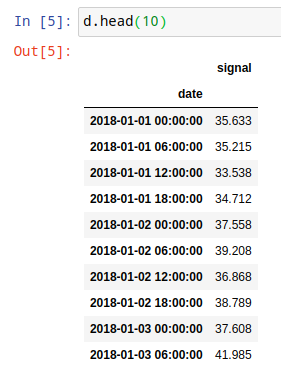

In [ ]:
Image("local/imgs/df_tseries1.png")

you should produce the following output

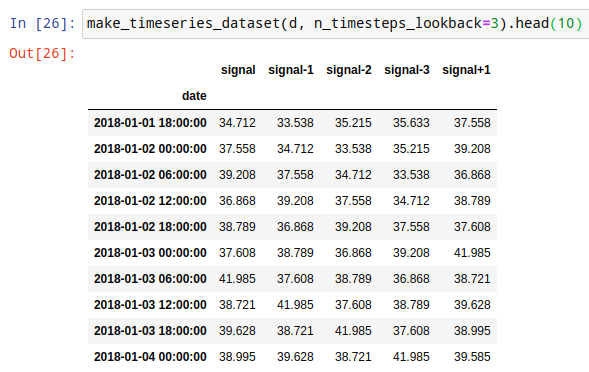

In [ ]:
Image("local/imgs/df_tseries2.png")

In [15]:
def make_timeseries_dataset(signal, n_timesteps_lookback):
    import pandas as pd
    r = signal.copy()

    r['signal+1'] = r['signal'].shift(-1)

    for i in range(1, n_timesteps_lookback + 1):
        r[f'signal-{i}'] = r['signal'].shift(i)

    new_column_order = ['signal'] + [f'signal-{i}' for i in range(1, n_timesteps_lookback + 1)] + ['signal+1']
    r = r[new_column_order]

    r = r.dropna()

    return r


test your code

In [17]:
make_timeseries_dataset(d, n_timesteps_lookback=3).head(10)

,signal,signal-1,signal-2,signal-3,signal+1
date,,,,,
2018-01-01 18:00:00,29.732,30.137,28.447,28.479,27.981
2018-01-02 00:00:00,27.981,29.732,30.137,28.447,29.132
2018-01-02 06:00:00,29.132,27.981,29.732,30.137,31.225
2018-01-02 12:00:00,31.225,29.132,27.981,29.732,28.522
2018-01-02 18:00:00,28.522,31.225,29.132,27.981,29.463
2018-01-03 00:00:00,29.463,28.522,31.225,29.132,30.192
2018-01-03 06:00:00,30.192,29.463,28.522,31.225,31.407
2018-01-03 12:00:00,31.407,30.192,29.463,28.522,30.595
2018-01-03 18:00:00,30.595,31.407,30.192,29.463,27.628


**submit your answer**

In [16]:
student.submit_task(globals(), task_id="task_01");

## Task 2. Manually apply a regression model to create predictions

Complete the following function to apply the a linear regression model to a dataframe such as the resulting one from the previous task:

$$\hat{y} = w_0 + w_1s + w_2s_{-1} + w_3s_{-2} + w_4s_{-3} ... $$

where $s$ corresponds to the column named `signal`, $s_{-1}$ to the column named `signal-1`, etc.

Observe that:

- column `signal+1` is not used, as it is the expected prediction. You will use it in the next task.
- you will have `n_timesteps_lookback`+2 $w$ parameters, since you will have one per each `n_timesteps_lookback`, plus $w_0$, plus $w_1$

Expect the function arguments as follow:

- `td`: a Pandas dataframe such as the output of the function `make_timeseries_dataset` of the previous task, with exactly the same column names
- `w`: a Numpy array with `n_timesteps_lookback`+2 elements in the order $[w_0, w_1, ...]$

**Warn**:  the DataFrame `td` may contain any number of lookback columns and might be in **any order**

**Challenge**: solve it with one single line of Python code

**EXAMPLE**: For the following dataframe and $w$

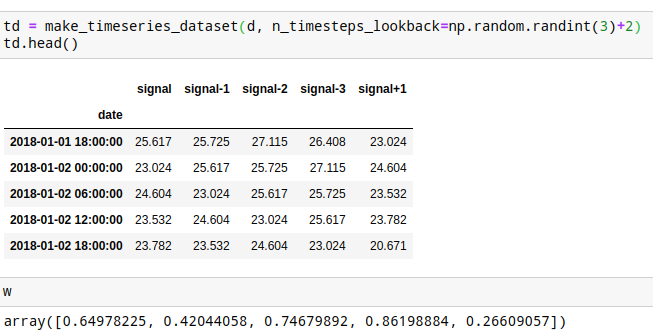

In [ ]:
Image("local/imgs/ts_reg_1.png")

you should get the following results

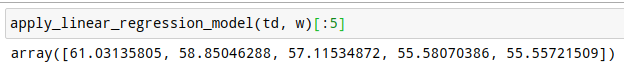

In [ ]:
Image("local/imgs/ts_reg_2.png")

In [54]:
def apply_linear_regression_model(td, w):
    signal_col = td['signal']
    lookback_cols = [td[f'signal-{i}'] for i in range(1, len(w) - 1)]

    prediction = w[0] + w[1] * signal_col
    for i in range(2, len(w)):
        prediction += w[i] * lookback_cols[i - 2]

    return prediction.to_numpy()

### test your code manually

observe how we permute the columns order

In [41]:
td = make_timeseries_dataset(d, n_timesteps_lookback=np.random.randint(3)+2)
td = td[np.random.permutation(td.columns)]
td.head()

,signal-1,signal,signal-4,signal+1,signal-3,signal-2
date,,,,,,
2018-01-02 00:00:00,29.732,27.981,28.479,29.132,28.447,30.137
2018-01-02 06:00:00,27.981,29.132,28.447,31.225,30.137,29.732
2018-01-02 12:00:00,29.132,31.225,30.137,28.522,29.732,27.981
2018-01-02 18:00:00,31.225,28.522,29.732,29.463,27.981,29.132
2018-01-03 00:00:00,28.522,29.463,27.981,30.192,29.132,31.225


In [46]:
w = np.random.random(len(td.columns))
w

array([0.6990611 , 0.57897893, 0.6868586 , 0.30176631, 0.30070806,
       0.95405327])

In [47]:
apply_linear_regression_model(td[np.random.permutation(td.columns)], w)[:5]

array([101.9535126 , 104.8487272 , 103.44903339, 102.17426946,
       104.4388446 ])

**submit your answer**

In [55]:
student.submit_task(globals(), task_id="task_02");

## Task 3: Measure trend prediction

You will now use the predictions to measure **trend accuracy**. We will compare any predictions which are given to us with the actual next value in column **signal+1** in the following way

- if **signal+1>signal** and ALSO your **prediction>signal**, then your model has a **correct trend prediction** regardless how different are **signal+1** and **prediction**
- if **signal+1<=signal** and ALSO your **prediction<=signal**, then your model has a **correct trend prediction** regardless how different are **signal+1** and **prediction**
- otherwise, your model has an **incorrect prediction**

Complete the following function such that when receiving a dataframe such as the resulting one from task 1 above, and a `pd.Series` with the same index and price predictions, computes the accuracy of the predictions (the percentage of correct predictions).

The accuracy must be a `float` and its correctness will be checked up to 2 decimal places.

**Challenge**: solve it with one single line of Python code.

**EXAMPLE**: for the following time series dataset

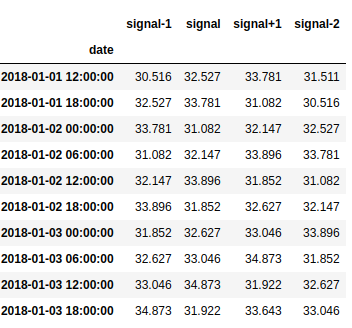

In [ ]:
Image("local/imgs/ts_reg_3.png")

And the following predictions

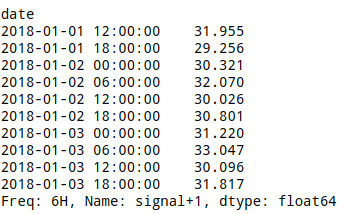

In [ ]:
Image("local/imgs/ts_reg_4.png")

The trend accuracy is `0.4` since the trend is correctly hit by the predictions on rows 1, 4, 7 and 8 (assuming the first row is numbered as 0)

In [67]:
def measure_trend_accuracy(td, preds):
    accuracy = ((td['signal+1'] > td['signal']) & (preds > td['signal'])).sum() + ((td['signal+1'] <= td['signal']) & (preds <= td['signal'])).sum()
    accuracy /= len(td)
    return round(accuracy, 11)

### test your code manually


In [68]:
td = make_timeseries_dataset(d, n_timesteps_lookback=np.random.randint(3)+2).iloc[:10]
td

,signal,signal-1,signal-2,signal-3,signal-4,signal+1
date,,,,,,
2018-01-02 00:00:00,27.981,29.732,30.137,28.447,28.479,29.132
2018-01-02 06:00:00,29.132,27.981,29.732,30.137,28.447,31.225
2018-01-02 12:00:00,31.225,29.132,27.981,29.732,30.137,28.522
2018-01-02 18:00:00,28.522,31.225,29.132,27.981,29.732,29.463
2018-01-03 00:00:00,29.463,28.522,31.225,29.132,27.981,30.192
2018-01-03 06:00:00,30.192,29.463,28.522,31.225,29.132,31.407
2018-01-03 12:00:00,31.407,30.192,29.463,28.522,31.225,30.595
2018-01-03 18:00:00,30.595,31.407,30.192,29.463,28.522,27.628
2018-01-04 00:00:00,27.628,30.595,31.407,30.192,29.463,31.032


In [69]:
preds = td['signal'] + np.round(np.random.random()*4-2,3)
preds

date
2018-01-02 00:00:00    27.745
2018-01-02 06:00:00    28.896
2018-01-02 12:00:00    30.989
2018-01-02 18:00:00    28.286
2018-01-03 00:00:00    29.227
2018-01-03 06:00:00    29.956
2018-01-03 12:00:00    31.171
2018-01-03 18:00:00    30.359
2018-01-04 00:00:00    27.392
2018-01-04 06:00:00    30.796
Freq: 6H, Name: signal, dtype: float64

In [70]:
measure_trend_accuracy(td, preds)

0.4

**submit your answer**

In [71]:
student.submit_task(globals(), task_id="task_03");